
Best Logistic Regression Parameters:
{'lr__C': 0.01, 'lr__class_weight': None, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82      1264
         1.0       0.09      0.73      0.17        52

    accuracy                           0.71      1316
   macro avg       0.54      0.72      0.50      1316
weighted avg       0.95      0.71      0.80      1316



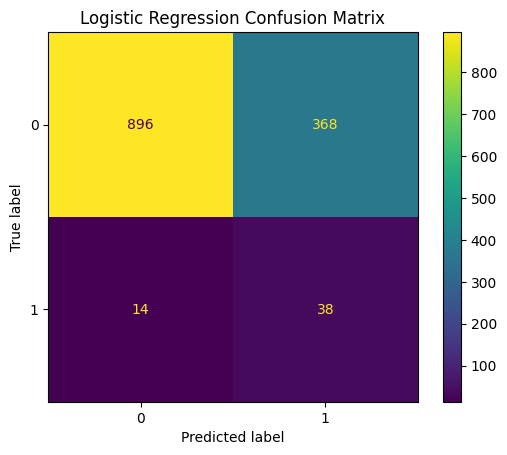

In [4]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df = df[df['gender'] != 'Other']
df = df.drop('id', axis=1)

# Encode Categorical Variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['ever_married'] = le.fit_transform(df['ever_married'])
df['Residence_type'] = le.fit_transform(df['Residence_type'])
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'], drop_first=True)

# Impute Missing Values with KNNImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Remove Outliers
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

for col in ['age', 'avg_glucose_level', 'bmi']:
    df_imputed = remove_outliers(df_imputed, col)

# Split Features and Target
X = df_imputed.drop('stroke', axis=1)
y = df_imputed['stroke']

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l1', 'l2'],
    'lr__class_weight': [None, 'balanced'],
    'lr__solver': ['liblinear']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Best Parameters and Evaluation
print("\nBest Logistic Regression Parameters:")
print(grid_search.best_params_)

best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test)

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()






